 # Settings
 ## 랜덤포레스트2

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [2]:
## 폰트 설정
mpl.rcParams['font.family'] = 'NanumGothic'

In [3]:
# 폰트바뀌었는지 확인
print (plt.rcParams['font.family'] )

['NanumGothic']


In [4]:
train = pd.read_csv('C:/Users/user/Desktop/workSpace/분석/데이터/bike-sharing-demand/train.csv', parse_dates = ["datetime"])
train.shape

(10886, 12)

In [5]:
test = pd.read_csv('C:/Users/user/Desktop/workSpace/분석/데이터/bike-sharing-demand/test.csv', parse_dates = ["datetime"])
test.shape

(6493, 9)

 # Feature Engineering

In [6]:
# train 데이터에 'datetime'을 나누어 추가
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["hour"] = train["datetime"].dt.hour
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 16)

In [7]:
# test 데이터에 "datetime"을 나누어 추가
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["hour"] = test["datetime"].dt.hour
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 13)

In [8]:
# 연속형 변수와 범주형 변수를 분리
# 범주형 변수의 type을 category로 변경
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [9]:
feature_names = ["season", "weather", "temp", "atemp", "humidity",
                 "year", "hour", "dayofweek", "holiday", "workingday"]


feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [10]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,14.395,81,2011,0,5,0,0
1,1,1,9.02,13.635,80,2011,1,5,0,0
2,1,1,9.02,13.635,80,2011,2,5,0,0
3,1,1,9.84,14.395,75,2011,3,5,0,0
4,1,1,9.84,14.395,75,2011,4,5,0,0


In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   weather     10886 non-null  category
 2   temp        10886 non-null  float64 
 3   atemp       10886 non-null  float64 
 4   humidity    10886 non-null  int64   
 5   year        10886 non-null  category
 6   hour        10886 non-null  category
 7   dayofweek   10886 non-null  category
 8   holiday     10886 non-null  category
 9   workingday  10886 non-null  category
dtypes: category(7), float64(2), int64(1)
memory usage: 331.5 KB


In [12]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,2011,0,3,0,1
1,1,1,10.66,13.635,56,2011,1,3,0,1
2,1,1,10.66,13.635,56,2011,2,3,0,1
3,1,1,10.66,12.880,56,2011,3,3,0,1
4,1,1,10.66,12.880,56,2011,4,3,0,1


In [13]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      6493 non-null   category
 1   weather     6493 non-null   category
 2   temp        6493 non-null   float64 
 3   atemp       6493 non-null   float64 
 4   humidity    6493 non-null   int64   
 5   year        6493 non-null   category
 6   hour        6493 non-null   category
 7   dayofweek   6493 non-null   category
 8   holiday     6493 non-null   category
 9   workingday  6493 non-null   category
dtypes: category(7), float64(2), int64(1)
memory usage: 198.5 KB


In [14]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

 # 모델평가 공식 (RMSLE)

In [17]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):

    if convertExp:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)
        
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    # 값이 0일 수도 있어서 로그를 취했을 때 마이너스 무한대가 될 수도 있기 때문에 1을 더해 줌
    # 로그를 씌워주는 것은 정규분포로 만들어주기 위해
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

 # 앙상블모델 - 랜덤포레스트
 ## Ensemble Models - Random Forest

In [18]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y_train)
rfModel.fit(X_train, y_train_log)

preds = rfModel.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Random Forest: ",score)

RMSLE Value For Random Forest:  0.10725462975358062


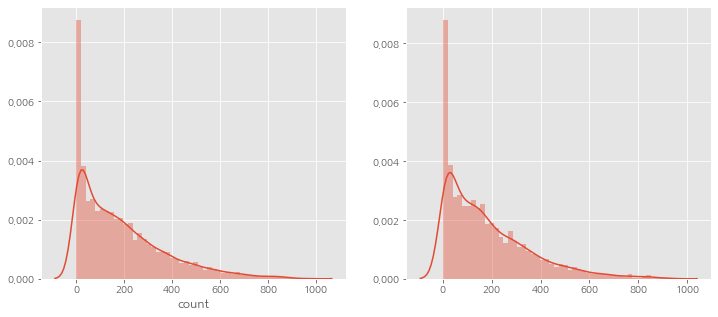

In [19]:
predsTest = rfModel.predict(X_test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)

In [23]:
submission = pd.read_csv("C:/Users/user/Desktop/workSpace/분석/데이터/bike-sharing-demand/sampleSubmission.csv")
submission

submission["count"] = np.exp(predsTest)

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.158302
1,2011-01-20 01:00:00,5.333607
2,2011-01-20 02:00:00,3.955573
3,2011-01-20 03:00:00,4.630983
4,2011-01-20 04:00:00,3.834513


In [21]:
submission.to_csv("C:/Users/user/Desktop/workSpace/분석/데이터/bike-sharing-demand/랜덤포레스트Score_{0:.5f}_submission.csv".format(score), index=False)